В нашем датасете собраны данные о предложении  на маркетплейсе Вайлдберриз демисезонной детской обуви для мальчиков и для девочек, почти 5000 наблюдений. Данные отсортированы по популярности на 18 марта 2024 года. Выборка сделана неслучайно, потому что детям в среднем покупается обувь раз в год (на 2 сезона). Признаки можно разделить на 3 группы.

Данные о бренде:
* brand - наименование бренда;
* brandId - идентификатор бренда;
* country - страна-производитель.

Данные о товаре:
* ids - артикулы;
* reviewRating - рейтинг товара;
* feedbacks - отзывы, которые оставили покупатели
* description - описание товара (дополнительная информация, оставленная продавцом);
* color - цвет товара;
* compound - состав товара;
* sole_material - материал подошвы;
* shoes_lining - материал подкладки;
* insole - материал стельки;
* sole_heighte - высота подошвы.

Целевой признак:
* price - цена товара в рублях.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать цену товара.

**Техническая задача:** построить модель машинного обучения, которая на основе предложенных характеристик будет предсказывать числовой признак - цену обуви. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Исследовать предоставленные данные и выявить закономерности.
2. Сгруппировать значения и заполнить пропуски.
3. Провести статистический анализ.
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике.


# Знакомство с данными и загрузка библиотек.

In [ ]:
!pip install pymorphy3

In [ ]:
!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np

# для визуализации
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# для проведения статистических тестов
import scipy.stats as st
from scipy.stats import ttest_ind, f_oneway

# для nlp-анализа
import pymorphy3
import pymorphy3_dicts_ru
import nltk
from nltk.tokenize import sent_tokenize
nltk.download("punkt")

# для машинного обучения
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import  SelectKBest,f_regression
from sklearn import metrics
import xgboost as xgb

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Data_Science/Final_DS/Wildberries_data.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Прочитаем данные.

In [ ]:
data = pd.read_csv('Wildberries_data.csv')
data = pd.read_csv(path)
data.head()

,ids,brand,brandId,reviewRating,feedbacks,price,description,color,compound,sole_material,shoes_lining,insole,sole_heighte,country
0,174745693.0,Baby Shoes Brand,40027509.0,4.8,4.0,763.0,Детские ботинки для девочки - это не просто об...,темно-серый,текстиль; резина; байка; искусственная кожа,резина,байка,искусственная кожа,NaN,Китай
1,167380350.0,Сказка,9968.0,4.7,210.0,1454.0,ВНИМАНИЕ! Выбирайте размер по размерной сетке ...,черный,искусственная кожа; байка,ТПР,байка,байка; ЭВА,NaN,Китай
2,191133786.0,Albant kids,485338.0,4.8,510.0,1007.0,Мягкие детские меховые домашние тапочки Акулы...,темно-синий,"искусственный мех, подошва ЭВА",ЭВА,NaN,NaN,NaN,Китай
3,147522381.0,STAR.,35381.0,4.8,575.0,886.0,Детские резиновые сапоги STAR.ANIMALS - это ид...,желтый,поливинилхлорид (ПВХ); флис; текстильный матер...,поливинилхлорид (ПВХ),NaN,NaN,NaN,Китай
4,148005189.0,SUMAY,518570.0,4.7,3461.0,1691.0,Длина по стельке: 23р-14.4см; 24р-14.9см; 25р-...,серебристый; розовый,экокожа 100%,ТЭП,Флис 100%; Байка 100%,Флис 100%; Байка 100%,2 см,Китай


# Разведывательный анализ.

In [ ]:
print('Размерность датафрейма: {} строк и {} столбцов.'.format(data.shape[0], data.shape[1]))
print()
display(data.info())
print()
print('Статистическая информация о числовых признаках:')
display(data.describe())
print()
print('Статистическая информация о категориальных признаках:')
display(data.describe(include='object'))

Размерность датафрейма: 4946 строк и 14 столбцов.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4946 entries, 0 to 4945
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ids            4945 non-null   float64
 1   brand          4934 non-null   object 
 2   brandId        4945 non-null   float64
 3   reviewRating   4945 non-null   float64
 4   feedbacks      4945 non-null   float64
 5   price          4945 non-null   float64
 6   description    4904 non-null   object 
 7   color          4903 non-null   object 
 8   compound       4801 non-null   object 
 9   sole_material  4727 non-null   object 
 10  shoes_lining   4295 non-null   object 
 11  insole         4206 non-null   object 
 12  sole_heighte   2615 non-null   object 
 13  country        4834 non-null   object 
dtypes: float64(5), object(9)
memory usage: 541.1+ KB


None


Статистическая информация о числовых признаках:


,ids,brandId,reviewRating,feedbacks,price
count,4.945000e+03,4.945000e+03,4945.000000,4945.000000,4945.000000
mean,1.424466e+08,2.330191e+07,4.636542,408.553893,1931.252578
std,5.650408e+07,8.070341e+07,0.664079,978.269870,974.970893
min,1.954876e+06,0.000000e+00,0.000000,0.000000,198.000000
25%,1.123573e+08,9.968000e+03,4.600000,35.000000,1288.000000
50%,1.662851e+08,1.681900e+04,4.800000,135.000000,1734.000000
75%,1.765420e+08,1.511700e+05,4.800000,345.000000,2371.000000
max,2.139621e+08,3.112688e+08,5.000000,12251.000000,12990.000000



Статистическая информация о категориальных признаках:


,brand,description,color,compound,sole_material,shoes_lining,insole,sole_heighte,country
count,4934,4904,4903,4801,4727,4295,4206,2615,4834
unique,475,3108,933,889,250,303,282,42,22
top,Shuzzi,Не спешите писать негативный отзыв при следующ...,черный,натуральная кожа,ТПР,текстиль,текстиль,2 см,Китай
freq,557,183,1468,413,1470,883,663,861,2806


В датафрейме 5 числовых признаков и 9 категориальных. Представлены 475 брендо из 22 стран. В целевом признаке медиана и средняя отличаются, это говорит о не нормальном распределении. Присутствуют выбросы.

Составим таблицу пропущенных значений.

In [ ]:
MissingValue = data.isnull().sum().sort_values(ascending = False)
Percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
MissingData = pd.concat([MissingValue, Percent], axis=1, keys=['Пропущенные значения','Процент'])
MissingData

,Пропущенные значения,Процент
sole_heighte,2331,47.128993
insole,740,14.961585
shoes_lining,651,13.162151
sole_material,219,4.427820
compound,145,2.931662
country,112,2.264456
color,43,0.869389
description,42,0.849171
brand,12,0.242620
ids,1,0.020218


Удалим признак "sole_heighte", так как пропусков более 30% и строку, где пропущено значение целевого признака.

In [ ]:
data.drop(axis=1, columns=['sole_heighte'], inplace=True)
data.dropna(subset=['price'], how='any', inplace = True)

Проверим датасет на наличие дубликатов. Если цены были зафиксированы на определенный день (18.03.2024), то подробные характеристики пришлось парсить несклько дней. В результате артикулы повторились. Удалим более свежие.

In [ ]:
print(f'Найдено дублирующих строк: {data.duplicated().sum()}')
print(f'Найдено строк с повторяющимися артикулами: {len(data.ids) - data.ids.nunique()}')
print()

print(data['ids'].value_counts().nlargest(7))
print()

del_index = [3776, 4385, 4388, 1393, 4664, 145, 714]
data.drop(index=del_index, inplace=True)
data.reset_index(drop=True, inplace=True)

Найдено дублирующих строк: 0
Найдено строк с повторяющимися артикулами: 7

ids
202838018.0    2
160429161.0    2
160429162.0    2
159053392.0    2
208692714.0    2
177622991.0    2
142005134.0    2
Name: count, dtype: int64



## Заполнение пропусков и группировка значений.

### *Обработка признаков "brand", "color" и "country".*

Признаки, где меньше всего пропусков, можно восстановить вручную.

In [ ]:
data['brand'] = data['brand'].fillna('No brand')

data['ids'] = data['ids'].astype('int')
data['brandId'] = data['brandId'].astype('int')

In [ ]:
ids_for_filling = list(data[data.color.isna() == True].ids.values)

color_values = {}

for id in ids_for_filling:
  if id == 175314831 or id ==176791315 or id == 146322507 or id == 210247568:
    color_values[id] = "черный; серый"
  elif id == 207796534:
    color_values[id] = 'черный; коричневый'
  elif id == 189053683 or id == 189053681 or id ==173224961 \
   or id == 96093539 or id == 3660292 or id == 17897866 or id == 207796535 \
   or id == 207796536 or id == 207796542 or id == 207796546 or id == 110344894 \
   or id == 107355023 or id == 210333454:
    color_values[id] = "черный"
  elif id == 147516513:
    color_values[id] = "голубой"
  elif id == 146377637 or id == 145837056 or id == 207796543:
    color_values[id] = "розовый"
  elif id == 155149479:
    color_values[id] = "голубой"
  elif  id == 146355195 or id == 147454504 or id == 146346923 \
  or id == 18930507:
    color_values[id] = "синий"
  elif id == 146369268 or id == 147466156:
    color_values[id] = 'зеленый'
  elif  id == 189053682 or id == 189053684 or id == 74503665:
    color_values[id] = "белый"
  elif id == 146188611 or id == 147461063:
    color_values[id] = 'желтый'
  elif id == 168600730 or id == 41656317:
    color_values[id] = 'серый'
  elif id == 151930469 or id == 19404517:
    color_values[id] = 'фиолетовый'
  elif id == 74540915:
    color_values[id] = 'синий; голубой'
  elif id == 61067580 or id == 19404512 or id == 210247569:
    color_values[id] = 'серый'

for key in color_values.keys():
  data.loc[data['ids'] == key, 'color'] = color_values[key]

Сгруппируем значения. Если указано несколько цветов, то значение будет "разноцветный". Если указан оттенок, указываем основной цвет. Например, "алый" => "красный".

In [ ]:
def color_grouping(color):
  color = color.lower().split(';')
  if len(color) > 1:
    color = 'разноцветный'
    return color
  if len(color) == 1:
    if color[0] in ['синий петроль','ярко-синий','сине-морской','cиняя волна',
                    'темно-синий','синий','черничный','черно-синий',
                    'синий космос','голубино-синий']:
      color = 'синий'
      return color
    if color[0] in ['серый меланж','коричнево-серый','зеленовато-серый',
                    'жемчужный серый','мышино-серый','серебристо-серый',
                    'серый графит','серебро',"темно-серый","серебристый",
                    'темно-серый','серый','светло-серый','розовато-серый',
                    'средне-серый']:
      color = 'серый'
      return color
    if color[0] in ['мята пыльная','серо-зеленый','светло-зеленый',
                    'светло серо-зеленый','зеленый', "хаки", 'лайм', 'мятный',
                    'салатовый','темно-зеленый','зеленый неон','бирюзовый']:
      color = 'зеленый'
      return color
    if color[0] in ['пурпур','красный','бордовый', "алый", 'красный каркаде']:
      color = 'красный'
      return color
    if color[0] in ['небесно-голубой','серо-голубой','голубой', 'джинс',
                    'светло-голубой']:
      color = 'голубой'
      return color
    if color[0] in ['белый иней',"молочный", 'белый','теплый белый']:
      color = 'белый'
      return color
    if color[0] in ['темно-фиолетовый','серо-фиолетовый','сливовый','фиолетовый',
                    'сине-фиолетовый',"сиреневый",'лавандовый','баклажановый',
                    'лиловый']:
      color = 'фиолетовый'
      return color
    if color[0] in ["оранжевый", "рыжий"]:
      color = "оранжевый"
      return color
    if color[0] in ['тускло-розовый','розовый персик','розовый антик',
                    'ярко-розовый','розовая пудра','пудровый','темно-розовый',
                    "розовый","фуксия",'розовый','коралловый','малиновый',
                    'светло-розовый','оливковый','пыльная роза', 'нежный розовый',
                    'светло-коралловый','розовый лимонад','ягодный',
                    'пастельно-розовый','глубокий коралловый', 'мягкий розовый',
                    'малиново-розовый']:
      color = "розовый"
      return color
    if color[0] in ['песочный','верблюжий','пастельно-песочный','золотистый',
                    'желтый', 'персиковый', 'охра']:
      color = 'желтый'
      return color
    if color[0] in ['желто-коричневый','кофе с молоком','кофейный',
                    'шоколадно-коричневый','мокко','красно-коричневый',
                    'бронзовый', 'светло-коричневый', 'темно-коричневый',
                    'коричневый']:
      color = 'коричневый'
      return color
    if color[0] in ['черный кристалл','чернильный',"чёрный",'черный меланж',
                    'черный','черный матовый','черный лакированный никел',
                    'глубокий черный', 'черный графит']:
      color = 'черный'
      return color
    if color[0] in ['нюдовый','белый песок','серо-бежевый','кремовый','бежевый',
                    'темно-бежевый', 'бежевый лайт','светло-бежевый',
                    'зернистый светло-бежевый','ванильно-бежевый']:
      color = 'бежевый'
      return color
    if color[0] in ['бежево-розовый','бело-розовый','бело-серый','бело-синий',
                    'черно-зеленый','черно-коричневый']:
      color = 'разноцветный'
      return color
    else: return color

data['color'] = data['color'].apply(color_grouping).astype('str')
data['color'].value_counts(dropna=False)

color
черный          1571
разноцветный    1465
синий            474
белый            335
розовый          302
серый            215
бежевый          148
зеленый          100
коричневый        88
желтый            76
фиолетовый        60
красный           59
голубой           23
оранжевый         22
Name: count, dtype: int64

Восстанавливаем значение страны-производителя (не страну, где бренд зарегистрирован!).

In [ ]:
brand_list = {
    'TITTOO': "Китай", 'TITTTO': "Китай", 'LLB brand': "Китай", 'tellson': "Китай",
    'OV&K': "Китай",'VaLaLi shoes': "Китай", 'Meitisi': "Китай", 'TDSHOP': "Китай",
    'JIE.REIMO': "Китай", 'AXMADIK': "Китай", 'Мерава': "Китай",
    'Amelka Karamelka': "Китай", 'LARIQLO KIDS': "Китай", 'СКАЗКА Shoes': "Китай",
     'Сказка': "Китай", 'Azimut C.O. Jewelry and Accessories': "Китай",
    'Charly': "Китай", 'КатяМиша': "Китай", 'Adidas': "Китай", 'Shkodina_Shop': "Китай",
    'NeSchool': "Китай", 'KAZZU': "Китай", 'd1d': "Китай", 'Корона кидс': "Китай",
    'DINO ALBAT': "Китай",

    'МИФЁР': 'Россия','Abu-Shoes': 'Россия', 'LOOKING.SHIK': 'Россия', 'Siyamico': 'Россия',
    'Котофей': 'Россия', 'M&D Shoes': 'Россия', 'Манки Shoes': 'Россия',
    'Indigo kids': 'Россия', 'Мягкотики': 'Россия', 'HAPPY & LOVELY': 'Россия',

    'Lovely Shoes': "Корея",
    'Joma': 'Испания',
    'United Colors of Benetton': 'Италия',
    'PEPE JEANS LONDON': 'Великобритания',
    'Leons bunny': 'Сербия',

    'New_balance': 'США', 'CROCS': 'США', 'VANS': 'США',

    'DR.MYMI': 'Турция', 'Tofino': 'Турция', 'DiSoShi': 'Турция',

    'МЕГА_TS': 'Вьетнам', 'BAAS': 'Вьетнам'
    }

for key in brand_list.keys():
  data.loc[data['brand'] == key, 'country'] = brand_list[key]

### *Обработка признака "sole_material".*

Для последующей работы напишем 2 функции, которые убирают из текста знаки препинания, символы и ненужную информацию в виде цифр. На разных этапах обработки нам могут понадобится цифры, поэтому сначала редактируется текст, а потом удаляются цифры. В любом случае на каждом этапе данные нужно оценивать.

In [ ]:
def edit_text(text):
  '''Функция, удаляющая знаки и символы для удобной работы со строками'''
  del_symbols = ['(', ')', '%', ';', ',', '-', '100', '50', '+', '.']
  for symbol in del_symbols:
    text = str(text).replace(symbol, ' ')
  return text

def delete_digit(text):
  '''Функция, удаляющая цифры из строки'''
  text = str(text)
  del_chars = ['0','1','2','3','4','5','6','7','8','9']
  for letter in text:
    if letter in del_chars:
      text = text.replace(letter, '')
  return text

Восстановим значения признака "sole_material". В настоящее время самыми популярными материалами для изготовления подошвы являются:

* полиуретан (ПУ),

* термополиуретан (ТПУ),

* поливинилхлорид (ПВХ),

* этиленвинилацетат (ЭВА),

* термопластичная резина (ТПР),

* термоэластопласт (ТЭП).

В случае, если продавец заполнил это поле, но формулировка размыта, значение идет в "прочие материалы". Также если продавец указывает преобладание какого-либо материала (например, "85% ЭВА"), наблюдение относится в соответствующую группу. Обычно продавцы на первом месте указывают материалы, доля которых наибольшая. Но встречаются исключения.

In [ ]:
def sole_types_grouping(material):
        # если основной материал ТЭП
  material = material.lower().split()
  if material[0] in ['термоэластопласт', 'тэп', 'термопластичный', 'тпэ',
                                                'термоэластопласта']\
  or 'каучук' in material:
    material = "ТЭП"
    return material

        # если основной материал ЭВА
  elif material[0] in ['эва','этиленвинилацетат', 'eva', 'эватэп',
        'эва/тэп', 'эватпр', 'филон', 'эварезина', 'эва/резина']\
  or material == ['85', 'этиленвинилацетат', '15', 'термоэластопласт']\
  or material == ['90', 'ацетат', '10', 'полиэстер']\
  or material == ['15', 'резина', '85', 'эва']\
  or material == ['70', 'эва', '30', 'резина']\
  or material == ['искусственная', 'резина', 'эва']\
  or material == ['70', 'филон', '30', 'резина'] :
      material = "ЭВА"
      return material

        # если основной материал ПВХ
  elif material[0] in ['поливинилхлорид', 'пвх', 'пвхполивинилхлорид', 'pvc']\
  or material == ['кроссовки', 'подростковые', 'на', 'широкой',
                       'платформе', 'пвх', 'pvc', 'поливинилхлорид']:
      material = "ПВХ"
      return material

        # если основной материал ТПР
  elif material[0] in ['tpr', 'тпр', 'tprтермопластичная','терморезина',
                                            'термопластичная', 'термопластическая', 'термопластична',
                                            'тпр/эва', 'трп'] \
  or material == ['резина', 'тпр']:
      material = "ТПР"
      return material

        # если основной материал резина
  elif material[0] in [' резина', 'микропористая', 'резиновая', 'резина']:
      material =  "прочие материалы" #"резина"
      return material

        # если основной материал полиуретан
  elif material[0] in ['полиуретан', 'пу', 'термополиуретан', 'пенополиуретан',
                                            'ролиуретан']\
  or material == ['морозоустойчивый', 'полиуретан', 'пу']:
      material = "ПУ"
      return material

        # если основной материал ТПУ
  elif material[0] == 'тпу':
      material = "ТПУ"
      return material

  elif material == ['nan']:
    return np.nan

  else:
    material = "прочие материалы"
    return material

data['sole_material'] = data['sole_material'].apply(edit_text)
data['sole_material'] = data['sole_material'].astype('str').apply(sole_types_grouping)
data['sole_material'].value_counts(dropna=False)

sole_material
ТПР                 1782
ТЭП                  885
прочие материалы     742
ЭВА                  687
ПВХ                  341
ПУ                   253
NaN                  218
ТПУ                   30
Name: count, dtype: int64

Попробуем восстановить пропущенные значения из признаков "description" и "compound". Поля "Описание" и "Состав" в основном изобилуют прилагательными, которые могут содержать полезную инормацию. Для этого напишем  2 функции. Первая поможет выделить предложения, где упоминается слово "подошва", а вторая поможет уточнить наименование материала (токен). Для удобства создадим 2 дополнительных признака, которые будут иметь расширения "_d"(информация из "description") и "_c"("compound").

Аналогично мы будем искать пропущенные значения для других признаков: "insole" и "shoes_lining".

In [ ]:
def sole_finder(description):
  "Функция, выделяющая предложение, которое содержит нужное слово"
  description = str(description).lower()
  sentences = sent_tokenize(description)

  insole_list = ['подошва','подошвы','подошву','подошве','подошвой', 'подошве']
  for sentence, word in zip(sentences, insole_list):
    if word in sentence:
      return sentence


def sole_sentence_editor(sentence):
  "Функция, выделяющая из предложения нужное слово"
  for word in sentence.split():
    if word in ['тэп','термопласта', 'термопластичной', 'термопластичную']:
      sentence = 'ТЭП'
      return sentence
    elif word in ['эва', 'этиленвинилацетат', 'этиленвинилацетата', 'филон'
        'филона']:
      sentence = "ЭВА"
      return sentence
    elif word in ['пвх' , 'поливинилхлорид', 'поливинилхлорида']:
      sentence = "ПВХ"
      return sentence
    elif word in ['тпр', 'терморезина', 'терморезины', 'термоплатичная',
                    'термопластичной', 'термостойкой', 'термостойкая',
                    'термостойкую']:
      sentence = "ТПР"
      return sentence
    elif word in ['резина', 'резиновая', 'резиновой', 'резиновую']:
      sentence = "резина"
      return sentence
    elif word in ['пу', 'полиуритан', 'полиуритановая', 'полиуритановой',
                       'полиуритановую', 'полиуретана']:
      sentence = 'ПУ'
      return sentence


data['sole_add_d'] = data['description'].astype('str').apply(edit_text)
data['sole_add_d'] = data['sole_add_d'].apply(sole_finder)
data['sole_add_d'] = data['sole_add_d'].astype('str').apply(sole_sentence_editor)

print('Из признака "description" извлечены следующие пропущенные значения:')
display(data[data['insole'].isna() == True]['sole_add_d'].value_counts(dropna=False))
print()

data['sole_add_c'] = data['description'].astype('str').apply(edit_text)
data['sole_add_c'] = data['compound'].astype('str').apply(sole_finder)
data['sole_add_c'] = data['sole_add_c'].astype('str').apply(sole_sentence_editor)

print('Из признака "compound" найдены следующие пропущенные значения:')
display(data[data['insole'].isna() == True]['sole_add_c'].value_counts(dropna=False))

Из признака "description" извлечены следующие пропущенные значения:


sole_add_d
None      595
ПВХ        58
резина     27
ЭВА        25
ТПР        14
ТЭП        14
ПУ          5
Name: count, dtype: int64


Из признака "compound" найдены следующие пропущенные значения:


sole_add_c
None    730
ЭВА       8
Name: count, dtype: int64

Заполним пропущенные ячейки найденными значениями и сразу удалим вспомогательные признаки.

In [ ]:
for i in range(data.shape[0]):
  if data.loc[i]['sole_material'] is np.nan == False:
    continue

  else:

    if data.loc[i]['sole_add_d'] is not None:
      data.at [i, 'sole_material'] = data.loc[i]['sole_add_d']
    elif data.loc[i]['sole_add_c'] is not None:
      data.at [i, 'sole_material'] = data.loc[i]['sole_add_c']

data.drop(columns=['sole_add_d', 'sole_add_c'], inplace=True)

### *Обработка признака "shoes_lining".*

Виды подкладок обуви можно разделить также на несколько крупных групп:
* текстиль,                                      
* кожа,                                                                 
* искусственный мех (шерсть),                              
* синтетический материал,
* натуральный мех (шерсть),             
* искусственная кожа,         
* без подкладки.  

Из этих же материалов изготавливаются стельки.
        

In [ ]:
# материал подкладки
def textile_grouping(shoes_lining):

  if shoes_lining == ['nan'] or shoes_lining == None: return np.nan

  else:

  # если основной материал флис
    if shoes_lining[0] in ['флис', 'флисовая', 'флисовый'] or \
    shoes_lining == ['дышащий', 'материал', 'флис']:
      shoes_lining = 'синтетический материал'#'флис'
      return shoes_lining

  # если основной материал текстиль
    elif shoes_lining[0] in ['ткань', 'текстильный', 'текстиль', 'текстильные',
                             'сетка', 'плюш','плюшевая', 'вискоза'] or \
    shoes_lining == ['утепленный', 'текстиль'] or \
    shoes_lining == ['утепленный', 'текстильный', 'материал']:
      shoes_lining = "текстиль"
      return shoes_lining

  # если основной материал натуральная кожа
    elif shoes_lining[0] == 'натуральная' and shoes_lining[1] == "кожа" or \
    shoes_lining == ['натуралньная', 'кожа'] or \
    (shoes_lining[0].isdigit()==True and shoes_lining[1] == 'натуральная') or \
    shoes_lining[0] == 'кожа' or \
    shoes_lining[0] == 'кожподкладка':
      shoes_lining = "кожа"
      return shoes_lining

  # если основной материал байка
    elif shoes_lining[0] in ['ворсин', 'байка', 'ворс', 'евробайка'] or \
    shoes_lining == ['шерстяная', 'байка'] or \
    shoes_lining == ['обувная', 'байка'] or \
    shoes_lining == ['хлопковая', 'байка']:
      shoes_lining =  "текстиль"#"байка"
      return shoes_lining

  # если основной материал хлопок
    elif shoes_lining[0] == 'хлопок':
      shoes_lining = "текстиль" #"хлопок"
      return shoes_lining

  # если основной материал шерсть
    elif shoes_lining[0] == 'натуральная' and shoes_lining[1] == 'шерсть' or \
    shoes_lining[0] in ['шерсть','велюр', 'фетр'] or \
    shoes_lining == ['меховая', 'овчина', 'натуральная'] or \
    shoes_lining == ['нат', 'шерсть'] or \
    shoes_lining == ['фетр', 'войлок', 'шерсть']:
      shoes_lining = "натуральный мех"#"шерсть"
      return shoes_lining

  # если основной материал мех
    elif shoes_lining[0] == 'мех' or \
    (shoes_lining[0] == 'натуральный' and  shoes_lining[1] == 'мех') or \
    shoes_lining == ['шерстяной', 'мех'] or \
    shoes_lining == ['натуральный', 'мех']:
      shoes_lining = "натуральный мех"
      return shoes_lining

  # если основной материал искусственный мех
    elif shoes_lining[0] in ['искусственный', 'экомех', 'евромех'] or \
    shoes_lining == ['эко', 'мех']:
      shoes_lining = "искусственный мех"
      return shoes_lining

  # если основной материал войлок
    elif shoes_lining[0] in ['войлок'] or \
    shoes_lining == ['натуральный', 'шерстяной', 'войлок', 'натуральная', 'кожа'] or \
    shoes_lining == ['натуральный', 'шерстяной', 'войлок']:
      shoes_lining = "натуральный мех"#"войлок"
      return shoes_lining

  # если основной материал искусственная шерсть
    elif shoes_lining[0] == 'искусственная' and shoes_lining[1] == 'шерсть':
      shoes_lining = "искусственный мех" #"искусственная шерсть"
      return shoes_lining

   # если основной материал искусственная кожа
    elif (shoes_lining[0] == 'искусственная' or shoes_lining[0] == 'искуственная')\
    and shoes_lining[1] == 'кожа' or \
    shoes_lining[0] == 'экокожа' or \
    (shoes_lining[0] == 'эко' and shoes_lining[1] == 'кожа'):
      shoes_lining = "искусственная кожа"
      return shoes_lining

    # если подкладки нет
    elif shoes_lining[0] in ['без', 'подкладки', 'бесподкладочные']:
      shoes_lining = "без подкладки"
      return shoes_lining

    # если основной материал синтетика
    else :
      shoes_lining = "синтетический материал"  #полиамид, кашемир искусственный, полиакрил, полиэстер
      return shoes_lining


data['shoes_lining'] = data['shoes_lining'].apply(edit_text)
data['shoes_lining'] = data['shoes_lining'].apply(delete_digit)
data['shoes_lining'] = data['shoes_lining'].apply(lambda text: text.lower().split())

data['shoes_lining'] = data['shoes_lining'].apply(textile_grouping)
data['shoes_lining'].value_counts(dropna=False)

shoes_lining
текстиль                  2849
NaN                        649
натуральный мех            433
синтетический материал     411
кожа                       373
искусственный мех          147
искусственная кожа          43
без подкладки               33
Name: count, dtype: int64

Адаптируем функции под поиск других материалов, а таже воспользуемся иструментом MorphAnalyzer(): он поможет поставить прилагательное в начальную форму (лемматизация). Важный нюанс: инструмент недоработан, прилагательные будут встречаться преимущественно в мужской форме.

In [ ]:
def lining_finder(description):
  "Функция, выделяющая предложение и нужное слово"
  description = str(description).lower()
  sentences = sent_tokenize(description)

  lining_list = ['подкладка','подкладки','подкладку','подкладке','подкладкой']
  for sentence, word in zip(sentences, lining_list):
    if word in sentence:
      return sentence


morph = pymorphy3.MorphAnalyzer()

def textile_sentence_editor(sentence):
  "Функция, выделяющая из предложения нужное слово"
  norm_form_sentence = []
  sentence = sentence.split()
  for el in sentence:
    norm_form = morph.parse(el)[0][2]
    norm_form_sentence.append(norm_form)

  for el in norm_form_sentence:
    if el=='синтетический' or el=='синтетическая':
      return 'синтетический материал'

    elif el=="шерстяной" or el=="шерстяная":
      return "натуральный мех"#'шерсть'

    elif el=="текстиль" or el=="байка" or el=='хлопок':
      return 'текстиль'

    elif el=="флис":
      return 'синтетический материал' #'флис'

    elif el=="войлок" or el=='войлочная' or el=='войлочный':
      return "натуральный мех" #"войлок"


data['lining_add_d'] = data['description'].apply(lining_finder)
data['lining_add_d'] = data['lining_add_d'].apply(edit_text)
data['lining_add_d'] = data['lining_add_d'].apply(textile_sentence_editor)
print('Из признака "description" извлечены следующие пропущенные значения:')
display(data[data.shoes_lining.isna()==True]['lining_add_d'].value_counts(dropna=False))
print()

data['lining_add_c'] = data['compound'].apply(lining_finder)
data['lining_add_c'] = data['lining_add_c'].apply(edit_text)
data['lining_add_c'] = data['lining_add_c'].apply(textile_sentence_editor)
print('Из признака "compound" найдены следующие пропущенные значения:')
display(data[data.shoes_lining.isna()==True]['lining_add_c'].value_counts(dropna=False))

Из признака "description" извлечены следующие пропущенные значения:


lining_add_d
None                      645
текстиль                    2
синтетический материал      1
натуральный мех             1
Name: count, dtype: int64


Из признака "compound" найдены следующие пропущенные значения:


lining_add_c
None    649
Name: count, dtype: int64

In [ ]:
for i in range(data.shape[0]):
  if data.loc[i]['shoes_lining'] is not None:
    continue

  else:

    if data.loc[i]['lining_add_d'] is not None:
      data.at [i, 'shoes_lining'] = data.loc[i]['lining_add_d']
    elif data.loc[i]['lining_add_c'] is not None:
      data.at [i, 'shoes_lining'] = data.loc[i]['lining_add_c']

data.drop(columns=["lining_add_d", "lining_add_c"], inplace=True)

### *Обработка признака "insole".*

Проведем аналогичную обработку для поиска информации и подкладке обуви: удаляем символы и цифры, понижаем регистр, ищем ключевые слова.


In [ ]:
data['insole'] = data['insole'].apply(edit_text)
data['insole'] = data['insole'].apply(delete_digit)
data['insole'] = data['insole'].apply(lambda text: text.lower().split())
data['insole'] = data['insole'].apply(textile_grouping)
data['insole'].value_counts(dropna=False)

insole
текстиль                  2372
кожа                       776
NaN                        738
натуральный мех            406
синтетический материал     391
искусственный мех          137
искусственная кожа          59
без подкладки               59
Name: count, dtype: int64

In [ ]:
def insole_finder(description):
  "Функция, выделяющая предложение и нужное слово"
  description = str(description).lower()
  sentences = sent_tokenize(description)

  lining_list = ['стелька','стельки','стельку','стельке','стелькой']
  for sentence, word in zip(sentences, lining_list):
    if word in sentence:
      return sentence


data['insole_add_d'] = data['description'].apply(insole_finder)
data['insole_add_d'] = data['insole_add_d'].apply(edit_text)
data['insole_add_d'] = data['insole_add_d'].apply(textile_sentence_editor)
print('Из признака "description" извлечены следующие пропущенные значения:')
display(data[data.insole.isna()==True]['insole_add_d'].value_counts(dropna=False))
print()

data['insole_add_c'] = data['compound'].astype('str').apply(lining_finder)
data['insole_add_c'] = data['insole_add_c'].apply(edit_text)
data['insole_add_c'] = data['insole_add_c'].apply(textile_sentence_editor)
print('Из признака "compound" найдены следующие пропущенные значения:')
display(data[data.insole.isna()==True]['insole_add_c'].value_counts(dropna=False))

Из признака "description" извлечены следующие пропущенные значения:


insole_add_d
None                      731
текстиль                    5
синтетический материал      2
Name: count, dtype: int64


Из признака "compound" найдены следующие пропущенные значения:


insole_add_c
None        737
текстиль      1
Name: count, dtype: int64

In [ ]:
# заполним пропущенные ячейки
for i in range(data.shape[0]):
  if data.loc[i]['insole'] is not None:
    continue

  else:

    if data.loc[i]['insole_add_d'] is not None:
      data.at [i, 'insole'] = data.loc[i]['insole_add_d']
    elif data.loc[i]['insole_add_c'] is not None:
      data.at [i, 'insole'] = data.loc[i]['insole_add_c']

data.drop(columns=['insole_add_d', 'insole_add_c'], inplace=True)

### *Создание и обработка признака "upper_material".*

Материал верха может быть изготовлен более разнообразных материалов. Будем использовать гибрид функций, которые группируют материалы подошвы и материалы подкладки/стельки.

In [ ]:
# материал верха
def upper_materials_grouping(upper_material):
  upper_material = upper_material.split()
  if upper_material == ['nan'] or upper_material == None: return np.nan

  else:
# если основной материал искусственная кожа
    if upper_material[0] == 'искусственная' and upper_material[1] == 'кожа' or \
    upper_material[0] == 'экокожа' or \
    (upper_material[0] == 'эко' and upper_material[1] == 'кожа') or \
    upper_material == ['искусственная', 'лаковая', 'кожа'] or \
    upper_material == ['искуственная', 'кожа'] or \
    upper_material == ['верх', 'лаковая', 'экокожа'] or \
    upper_material == ['лакированная', 'искусственная', 'кожа'] or \
    upper_material == ['лакированная', 'экокожа'] or \
    upper_material == ['иск', 'кожа'] or \
    upper_material == ['экокжа'] or \
    upper_material == ['верх', 'экокожа'] or \
    upper_material == ['высококачественная', 'экокожа', '/',
                       'текстиль',' /', 'пвх', 'подошва'] or\
    upper_material == ['верх:', 'эко', 'кожа'] or \
    upper_material == ['верх:', 'экокожа'] or \
    upper_material == ['высококачественная', 'искусственная', 'кожа']  or \
    upper_material == ['материал', 'верха', 'искусственная', 'кожа'] or \
    upper_material == ['искусственна', 'кожа'] or \
    upper_material == ['кожзаменитель'] or \
    upper_material == ['комбинированная', 'кожа'] or \
    upper_material == ['высококачественная', 'экокожа', '/', 'текстиль', '/',
                       'пвх', 'подошва']:
      upper_material = "искусственная кожа"
      return upper_material

# если основной материал натуральная кожа
    elif upper_material[0] == 'натуральная' and upper_material[1] == 'кожа' or \
    upper_material == ['кожа','натуральная'] or \
    upper_material[0] == 'кожа' or \
    upper_material == ['натуральная', 'лаковая', 'кожа'] or \
    upper_material == ['верх', 'натуральная', 'кожа'] or \
    upper_material == ['верх:', 'натуральная', 'кожа'] or \
    upper_material == ['верх', 'натуральная', 'лаковая', 'кожа']:
      upper_material = "натуральная кожа"
      return upper_material

# если основной материал текстиль
    elif upper_material[0] in ['текстиль', 'текстильный', 'ткань', 'хлопок', 'байка']:
      upper_material = "текстиль"
      return upper_material

    elif upper_material[0] in ['полиуретан']:
      upper_material = "полиуретан"
      return upper_material

    elif upper_material[0] in ['поливинилхлорид', 'пвх', 'пвхполивинилхлорид',
                               'pvc'] or \
    upper_material == ['био', 'пвх']:
      upper_material = "ПВХ"
      return upper_material

    elif upper_material[0] in ['эва','этиленвинилацетат', 'eva', 'эватэп',
        'эва/тэп', 'эватпр', 'филон', 'эварезина', 'эва/резина'] or \
    upper_material == ['материал', 'верха', 'эва'] :
      upper_material = "ЭВА"
      return upper_material

    elif upper_material[0] in ['tpr', 'тпр', 'tprтермопластичная','терморезина',
                               'термопластичная', 'термопластическая',
                               'термопластична','тпр/эва', 'трп']:
      upper_material = "ТПР"
      return upper_material

    elif upper_material[0] in ['термоэластопласт','тэп','термопластичный','тпэ',
                               'каучук','термопласт','термоэластопласта']:
      upper_material = "ТЭП"
      return upper_material

    elif upper_material[0] in ['резина', 'пенорезина'] or \
    upper_material == ['качественная', 'резина'] or \
    upper_material == ['искусственная', 'резина']:
      upper_material = 'прочие материалы' #'резина'
      return upper_material

    elif upper_material == ['натуральный', 'нубук'] or \
    upper_material == ['нубук', 'натуральный'] or \
    upper_material == ['замша'] or \
    upper_material == ['нубук'] or \
    upper_material == ['замша', 'натуральная'] or \
    upper_material == ['натуральная', 'замша'] or \
    upper_material == ['верх', 'натуральный', 'нубук'] or \
    upper_material == ['верх:', 'замша'] or \
    upper_material == ['натуральной', 'нубук']:
      upper_material = "нубук / замша"
      return upper_material

    else:
      upper_material = "прочие материалы"
      return upper_material


data['upper_material'] = data.compound.astype('str').apply(lambda matirial: matirial.lower().split(';')[0])
data['upper_material'] = data.upper_material.apply(edit_text)
data['upper_material'] = data.upper_material.apply(delete_digit)
data['upper_material'] = data.upper_material.apply(upper_materials_grouping)
data['upper_material'].value_counts(dropna=False)[:40]

upper_material
искусственная кожа    2126
натуральная кожа      1051
текстиль               489
прочие материалы       447
ПВХ                    200
ЭВА                    180
нубук / замша          146
NaN                    143
полиуретан             122
ТЭП                     20
ТПР                     14
Name: count, dtype: int64

Адаптируем функии для поиска информации о материале верха.

In [ ]:
def upper_mat_finder(description):
  "Функция, выделяющая предложение, которое содержит нужное слово"
  description = str(description).lower()
  sentences = sent_tokenize(description)

  upper_mat_list = ['верх','верха','выполнены','выполнен','пинетки','пинеточки']
  for sentence, word in zip(sentences, upper_mat_list):
    if word in sentence:
      return sentence


def upper_sentence_editor(sentence):
  "Функция, выделяющая из предложения нужное слово"
  norm_form_sentence = []
  sentence = sentence.split()
  for el in sentence:
    norm_form = morph.parse(el)[0][2]
    norm_form_sentence.append(norm_form)

  for el in norm_form_sentence:
    if el=='пинетки' or el=='пинеточки' or el=='ткань':
      return 'текстиль'

    elif el=="резина":
      return 'прочие материалы' #'резина'

    elif el=='натуральная' or el=='гладкой' or el=='натуральной'or \
    el=='натуральный' or el=='гладкий':
      return 'натуральная кожа'

    elif el=="искусственная" or el=="искусственной" or el=='искусственный':
      return "искусственная кожа"

    elif el=='softshell':
      return 'прочие материалы'

data['upper_add_d'] = data['description'].apply(upper_mat_finder)
data['upper_add_d'] = data['upper_add_d'].apply(edit_text)
data['upper_add_d'] = data['upper_add_d'].apply(upper_sentence_editor)
print('Из признака "description" извлечены следующие пропущенные значения:')
display(data[data.upper_material.isna()==True]['upper_add_d'].value_counts(dropna=False))
print()
data['upper_add_c'] = data['compound'].apply(upper_mat_finder)
data['upper_add_c'] = data['upper_add_c'].apply(edit_text)
data['upper_add_c'] = data['upper_add_c'].apply(upper_sentence_editor)
print('Из признака "compound" извлечены следующие пропущенные значения:')
display(data[data.upper_material.isna()==True]['upper_add_c'].value_counts(dropna=False))

Из признака "description" извлечены следующие пропущенные значения:


upper_add_d
None                  125
натуральная кожа       12
прочие материалы        4
искусственная кожа      1
текстиль                1
Name: count, dtype: int64


Из признака "compound" извлечены следующие пропущенные значения:


upper_add_c
None    143
Name: count, dtype: int64

In [ ]:
# Заполнение пропущенных ячеек найденными значениями
for i in range(data.shape[0]):
  if data.loc[i]['upper_material'] is not None:
    continue

  else:

    if data.loc[i]['upper_add_d'] is not None:
      data.at [i, 'upper_material'] = data.loc[i]['upper_add_d']
    elif data.loc[i]['upper_add_c'] is not None:
      data.at [i, 'upper_material'] = data.loc[i]['upper_add_c']

data.drop(columns=['upper_add_d', 'upper_add_c'], inplace=True)

## Статистический анализ.

Удалим пропуски в строках и признаки 'description' и 'compound', так как для дальнейшей работы они не понадобятся. Далее почистим датасет от выбросов по методу Тьюки и оценим распределение.

In [ ]:
data.drop(columns=['description', 'compound'], inplace=True)
data.dropna(subset=['insole','sole_material','shoes_lining', 'upper_material'], \
            how='any', inplace = True)

In [ ]:
perc_75 = np.percentile(data['price'], 75)
perc_25 = np.percentile(data['price'], 25)
IQR = perc_75 - perc_25
print(f"Межквартильный размах: {IQR}.")
print(f"Границы выбросов: от {perc_25 - 1.5*IQR} до {perc_75 + 1.5*IQR}.")

Межквартильный размах: 1105.5.
Границы выбросов: от -268.0 до 4154.0.


In [ ]:
data = data[data.price <= perc_75 + 1.5*IQR].copy()

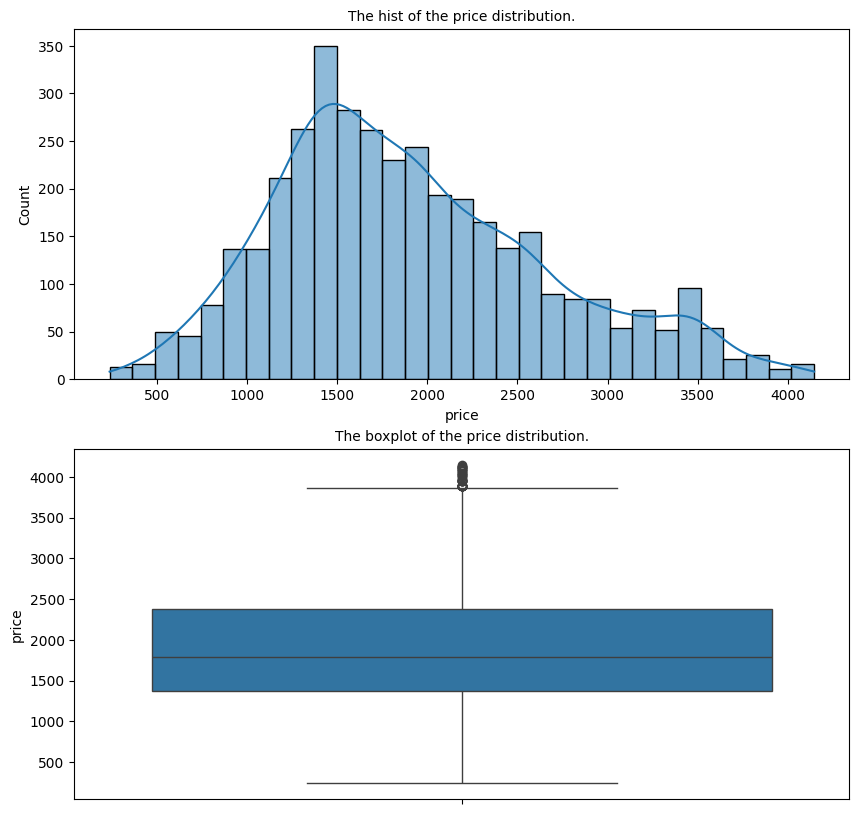


p-value=0.0
Данные не распределены нормально (мы отвергаем H0)


In [ ]:
# ваш код здесь
fig, axe = plt.subplots(2, 1, figsize=(10, 10))

axe[0].set_title('The hist of the price distribution.',
                 fontsize=10)
sns.histplot(data['price'],
             kde=True,
             ax=axe[0])

axe[1].set_title('The boxplot of the price distribution.',
                 fontsize=10)
sns.boxplot(data['price'],
            ax=axe[1])
plt.show()

# Проведем статтест на нормальность распределения
print()

H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

alpha = 0.05

res = st.normaltest(data['price'])
print(f'p-value={round(res.pvalue, 4)}')

if res.pvalue > alpha/2:
	print(H0)
else:
	print(Ha)

Тест Д'Агостино подтвердил, что распределение не является нормальным. Более того, оно ассиметрично и смещено вправо (мода < медианы).

Оценим влияние числовых признаков на целевой.

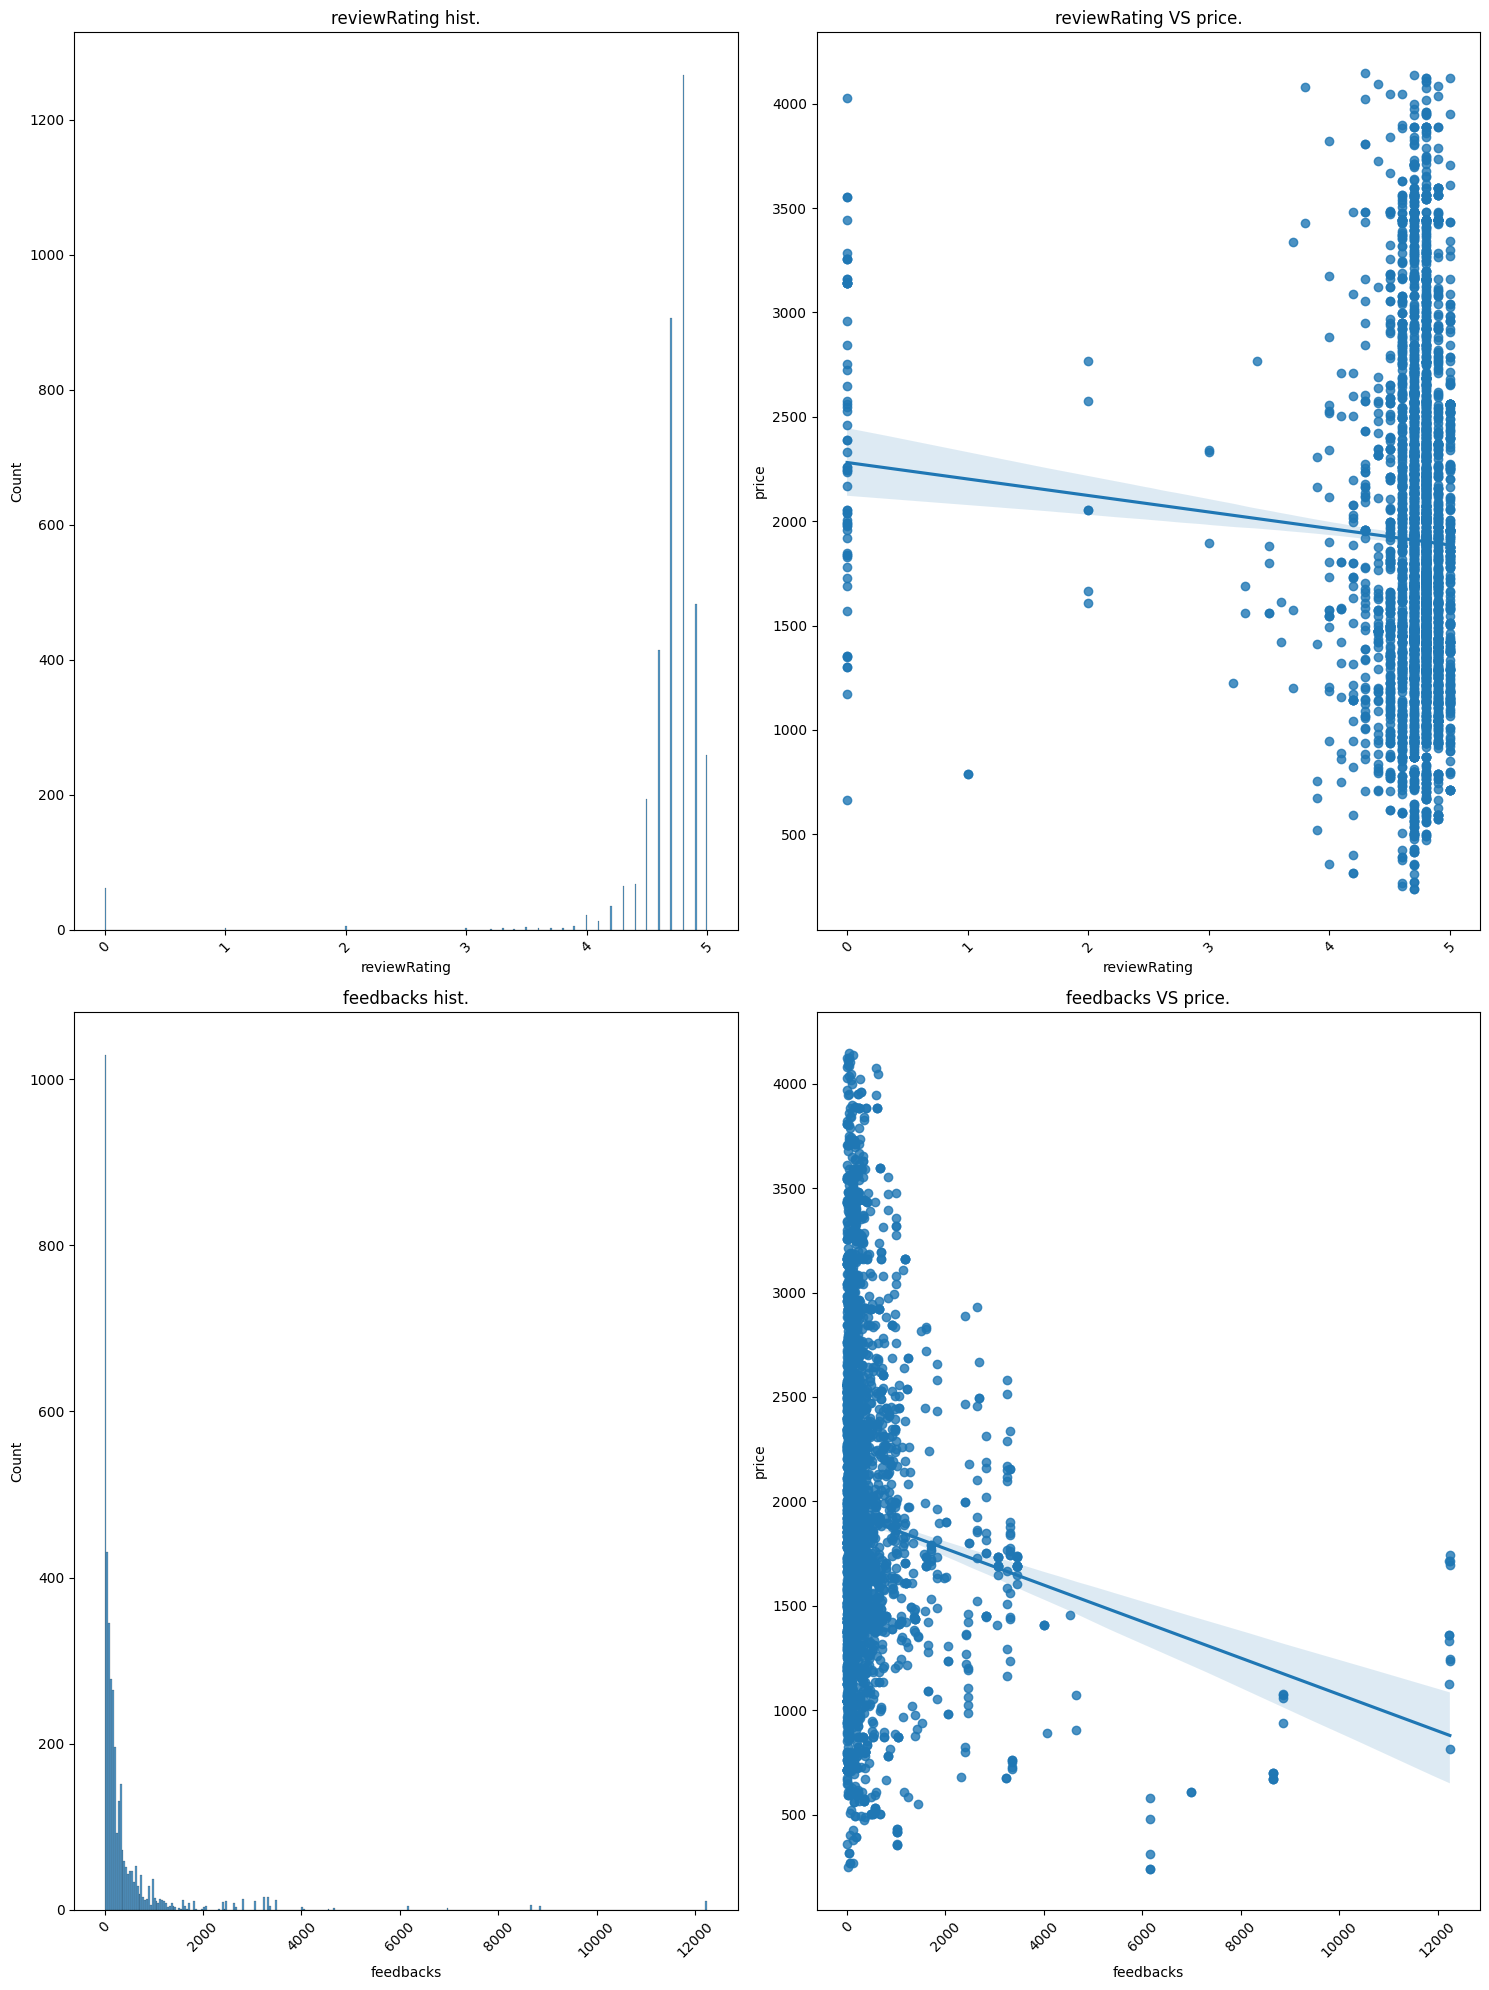

In [ ]:
features = ['reviewRating', 'feedbacks', 'price']
rate_data = data[features].reset_index(drop=True)

fig, axes = plt.subplots(2, 2, figsize=(15, 20))

for i, feature in enumerate(features[:2]):

    #Строим гистограмму распределения признака
    histplot = sns.histplot(data=rate_data, x=feature, ax=axes[i][0])
    histplot.set_title(f'{feature} hist.')
    histplot.xaxis.set_tick_params(rotation=45)

    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=rate_data, x=feature, y='price', ax=axes[i][1])
    regplot.set_title(f'{feature} VS price.')
    regplot.xaxis.set_tick_params(rotation=45)

plt.tight_layout()

Графики показывают, что прямой зависимости от цены от рейтинга нет. Более того, покупатели оценивают товар либо хорошо (4-5), либо плохо (0-1). Вариантов 2 и 3 очень мало. Более 12тыс. покупателей оставили свои отзывы на товар стоимостью до 2 тыс.руб. Но таких товаров немного, даже на графике видно, что их до 10 шт. У основной массы товаров до 1000 отзывов.

Познакомимся поближе с графиком зависимости средней цены от рейтинга. А также посмотрим как средний рейтинг зависит от цены.

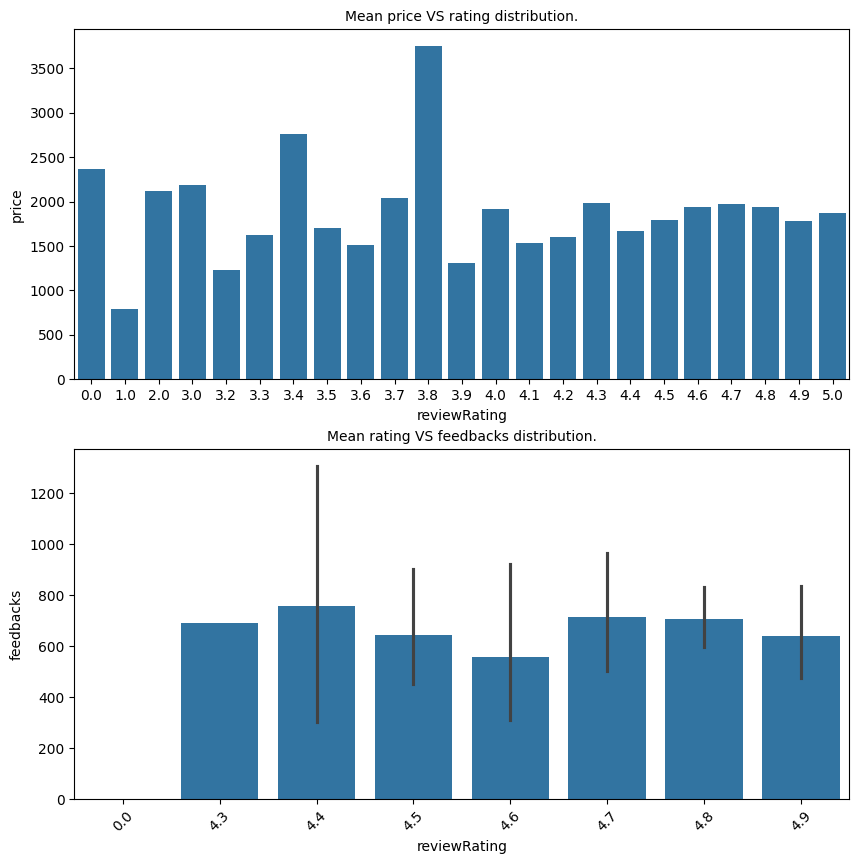

In [ ]:
rating_data = data.groupby('reviewRating', as_index=False)['price'].mean()
feedback_data = data.groupby(['feedbacks'], as_index=False)['reviewRating'].mean()
feedback_data['reviewRating'] = feedback_data['reviewRating'].apply(lambda x: round(x, 1))

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].set_title('Mean price VS rating distribution.',
                  fontsize=10)
sns.barplot(rating_data,
            x = 'reviewRating',
            y = 'price',
            ax=axes[0])
#axes[0].xaxis.set_tick_params(rotation=45)

axes[1].set_title('Mean rating VS feedbacks distribution.',
                 fontsize=10)
sns.barplot(feedback_data,
            x = 'reviewRating',
            y = 'feedbacks',
            ax=axes[1])
axes[1].xaxis.set_tick_params(rotation=45)

plt.show()

У дорогой обуви (более 3000 руб.) средний рейтинг 3.8, что недотягивает до отметки "хорошо". Возможно, это связано с завышенными ожиданиями. Остальные оценки колеблятся в районе значений до 2500.

Посмотрим из каких стран обувь самая дорогая и обувь из какой страны больше всего на рынке.

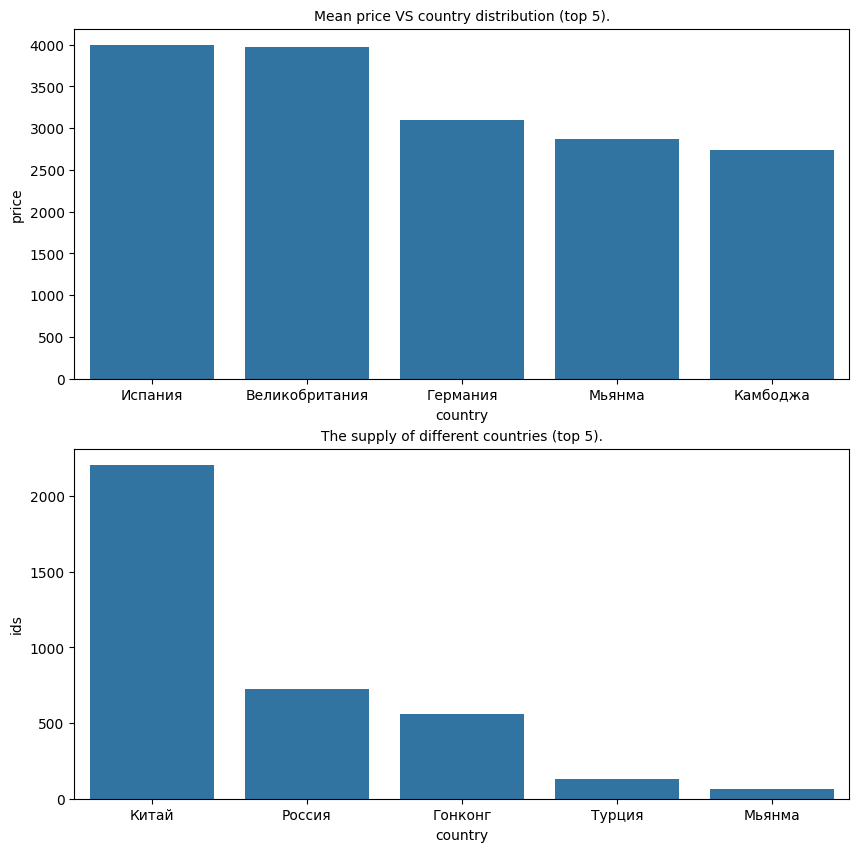

In [ ]:
price_data = data.groupby('country', as_index=False)['price'].mean().nlargest(5, 'price')
supply_data = data.groupby('country', as_index=False)['ids'].count().nlargest(5, 'ids')

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].set_title('Mean price VS country distribution (top 5).',
                 fontsize=10)
sns.barplot(price_data,
            x = 'country',
            y = 'price',
            ax=axes[0])

axes[1].set_title('The supply of different countries (top 5).',
                 fontsize=10)
sns.barplot(supply_data,
            x ='country',
            y ='ids',
            ax=axes[1])

plt.show()

Самая дорогая обуь из Великобритании, Испании и Германии, что вероятнее всего всязано с текщей экономической и политической обстановкой. Лидер по предложению Китай, с большим отрывом идет Россия. Гонконг пока не добился независимости, его таже можно отнести к Китаю.

Посмотрим зависимости категориальных признаков от целевого.

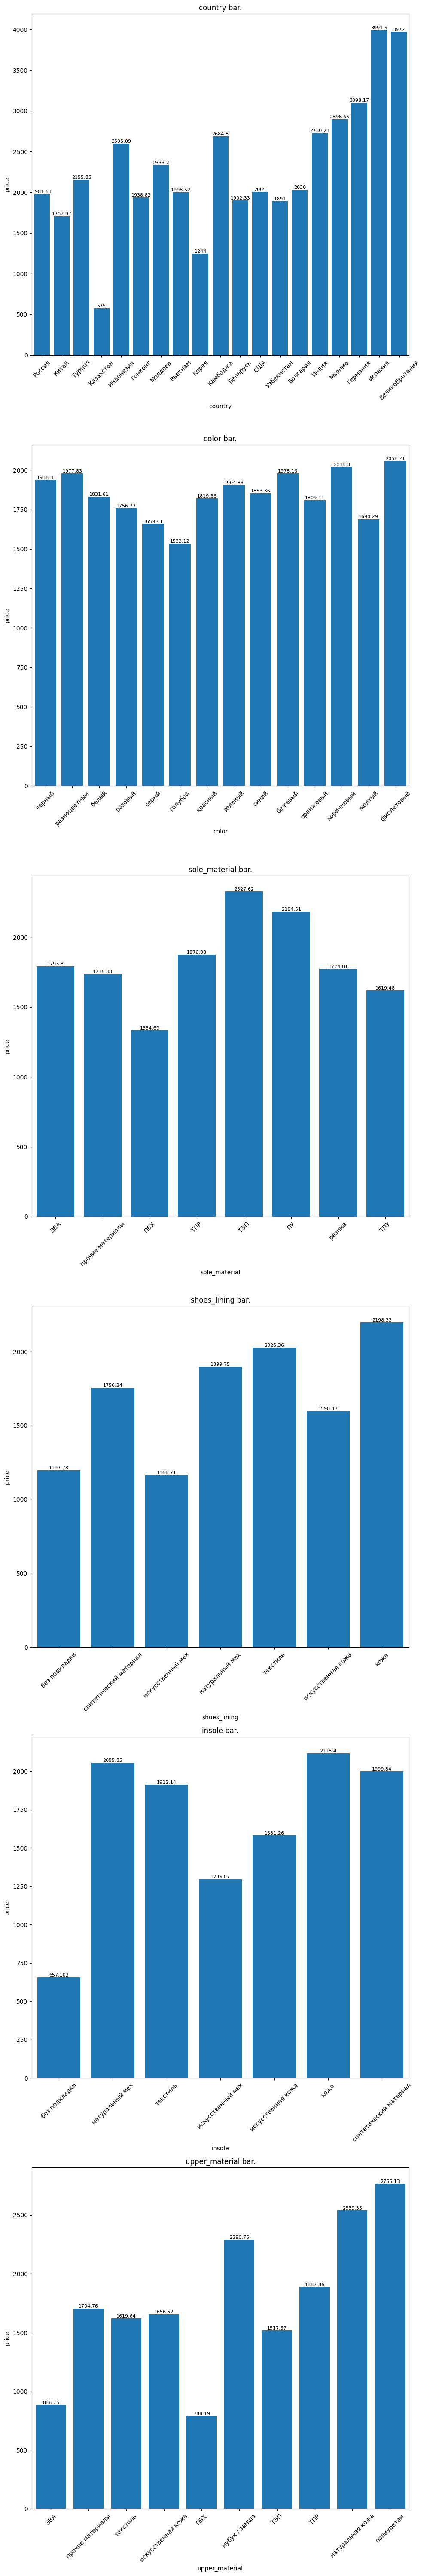

In [ ]:
features = ['country','color','sole_material', 'shoes_lining', 'insole','upper_material']
price_data = data.groupby(features, as_index=False)['price'].mean().sort_values(by='price')

fig, axes = plt.subplots(6, 1, figsize=(10, 60))

for i, feature in enumerate(features):

    #Строим столбчатую диаграмму распределения признака
    barplot = sns.barplot(data=price_data,
                           x=feature,
                           y='price',
                           errorbar=None,
                           saturation=2.0,
                           ax=axes[i])
    barplot.set_title(f'{feature} bar.')
    barplot.bar_label(barplot.containers[0], fontsize=8)
    barplot.xaxis.set_tick_params(rotation=45)


plt.tight_layout()

Сильнее всего цена зависит от страны-производителя, остальные признаки не так сильно колеблятся. Проведем несколько статистических тестов

In [ ]:
H0 = 'Нет значимой разницы между средней ценой обуви из Китая и обувью из стран СНГ.'
Ha = 'Есть значимая разница между средней ценой обуви из Китая и обувью из стран СНГ.'

china_prices = data[data.country == 'Китай']['price']
cis_prices = data[(data.country == "Казахстан")|
  (data.country == "Молдова")|
  (data.country == "Россия")|
  (data.country == "Узбекистан")]["price"]

print('\n' + "*** Результаты независимого T-теста ***")
test_results = ttest_ind(china_prices, cis_prices, equal_var=True)
p = round(test_results[1],2)

if p>alpha:
  print(f"{p} > {alpha}. Мы не можем отвергнуть нулевую гипотезу. \n{H0}")
else:
  print(f"{p} <= {alpha}. Мы отвергаем нулевую гипотезу. \n{Ha}")


*** Результаты независимого T-теста ***
0.0 <= 0.05. Мы отвергаем нулевую гипотезу. 
Есть значимая разница между средней ценой обуви из Китая и обувью из стран СНГ.


In [ ]:
H0 = 'Нет значимой разницы между среднней ценой обуви из натуральной кожи и обувью из экокожи.'
Ha = 'Есть значимая разница между среднней ценой обуви из натуральной кожи и обувью из экокожи.'

leather_data = data[data.upper_material == 'натуральная кожа']['price']
eco_leather_data = data[data.upper_material == 'искусственная кожа']['price']

print('\n' + "*** Результаты независимого T-теста ***")
test_results = ttest_ind(leather_data, eco_leather_data, equal_var=True)
p = round(test_results[1],2)

if p>alpha:
  print(f"{p} > {alpha}. Мы не можем отвергнуть нулевую гипотезу.\n{H0}")
else:
  print(f"{p} <= {alpha}. Мы отвергаем нулевую гипотезу.\n{Ha}")


*** Результаты независимого T-теста ***
0.0 <= 0.05. Мы отвергаем нулевую гипотезу.
Есть значимая разница между среднней ценой обуви из натуральной кожи и обувью из экокожи.


In [ ]:
asia_prices = data[(data.country == "Вьетнам") |
  (data.country =="Гонконг") |
  (data.country =="Индия") |
  (data.country =="Индонезия") |
  (data.country =="Камбоджа")|
  (data.country =="Корея")|
  (data.country =="Мьянма")]["price"]

H0 = 'Нет значимой разницы между среднней ценой обуви из Китая и обуви из других азиатских стран.'
Ha = 'Есть значимая разница между среднней ценой обуви из Китая и обуви из других азиатских стран.'

print('\n' + "*** Результаты независимого T-теста ***")
test_results = ttest_ind(china_prices, asia_prices, equal_var=True)
p = round(test_results[1],2)

if p>alpha:
  print(f"{p} > {alpha}. Мы не можем отвергнуть нулевую гипотезу. {H0}")
else:
  print(f"{p} <= {alpha}. Мы отвергаем нулевую гипотезу.\n {Ha}")



*** Результаты независимого T-теста ***
0.0 <= 0.05. Мы отвергаем нулевую гипотезу.
 Есть значимая разница между среднней ценой обуви из Китая и обуви из других азиатских стран.


In [ ]:
H0 = 'Нет значимой разницы между средней ценой обуви черного цвета, бежевого цвета и разноцветной.'
Ha = 'Есть значимая разница между среднней ценой обуви черного цвета, бежевого цвета и разноцветной.'

print('\n' + "*** Результаты однофакторного дисперсионного анализа ***")
_, p = f_oneway(data[data.color == 'черный']['price'],
                data[data.color == 'бежевый']['price'],
                data[data.color == 'разноцветный']['price'])
p = round(p,2)
if p>alpha:
  print(f"{p} > {alpha}. Мы не можем отвергнуть нулевую гипотезу.\n {H0}")
else:
  print(f"{p} <= {alpha}. Мы отвергаем нулевую гипотезу.\n {Ha}")


*** Результаты однофакторного дисперсионного анализа ***
0.0 <= 0.05. Мы отвергаем нулевую гипотезу.
 Есть значимая разница между среднней ценой обуви черного цвета, бежевого цвета и разноцветной.


# Преобразование и отбор признаков.

Подготовим датасет для обучения и отберем нужные признаки.

Несмотря на то, что 'ids' и 'brandId' числовые признаки, они не несут математического смысла и только сбивают модель с толку. Поэтому удалим их.

In [ ]:
data.drop(columns=['ids','brandId'], inplace=True)

Проведем OneHotEncoding и нормализуем признаки с помощью MinMaxScaler, т.к. распределение не нормальное, датасет от выбросов очищен.

In [ ]:
data = pd.get_dummies(data, drop_first=True)

scaler = MinMaxScaler()
data_scaled = data[['reviewRating','feedbacks']]
columns = ['reviewRating','feedbacks']
scaler.fit(data_scaled)

data_scaled = scaler.transform(data_scaled)
data[columns] = data_scaled

Разделим данные на обучающий и тестовый наборы. Выберем наилучшие 25 признаков, и если будут пары признаков с высокой корреляцией, удалим один из пары.

In [ ]:
y = data['price']
X = data.drop(columns='price')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

SKBest = SelectKBest(f_regression, k=25)
SKBest.fit(X, y)
best_features = SKBest.get_feature_names_out()
print(f'Наиболее значимые признаки:\n {best_features}')

Наиболее значимые признаки:
 ['brand_BEST.A' 'brand_BOS' 'brand_BOTTILINI' 'brand_Biker'
 'brand_EVASHOES' 'brand_GEOX' 'brand_Honey girl' 'brand_IRIDIS'
 'brand_T.TACCARDI' 'brand_TAPiBOO' 'brand_TimeJump' 'brand_Котофей'
 'brand_ЛЕЛЬ' 'color_разноцветный' 'sole_material_ТПР' 'sole_material_ТЭП'
 'shoes_lining_искусственный мех' 'insole_искусственный мех'
 'country_Китай' 'country_Мьянма' 'country_Россия'
 'upper_material_искусственная кожа' 'upper_material_натуральная кожа'
 'upper_material_полиуретан' 'upper_material_текстиль']


Построим тепловую карту.

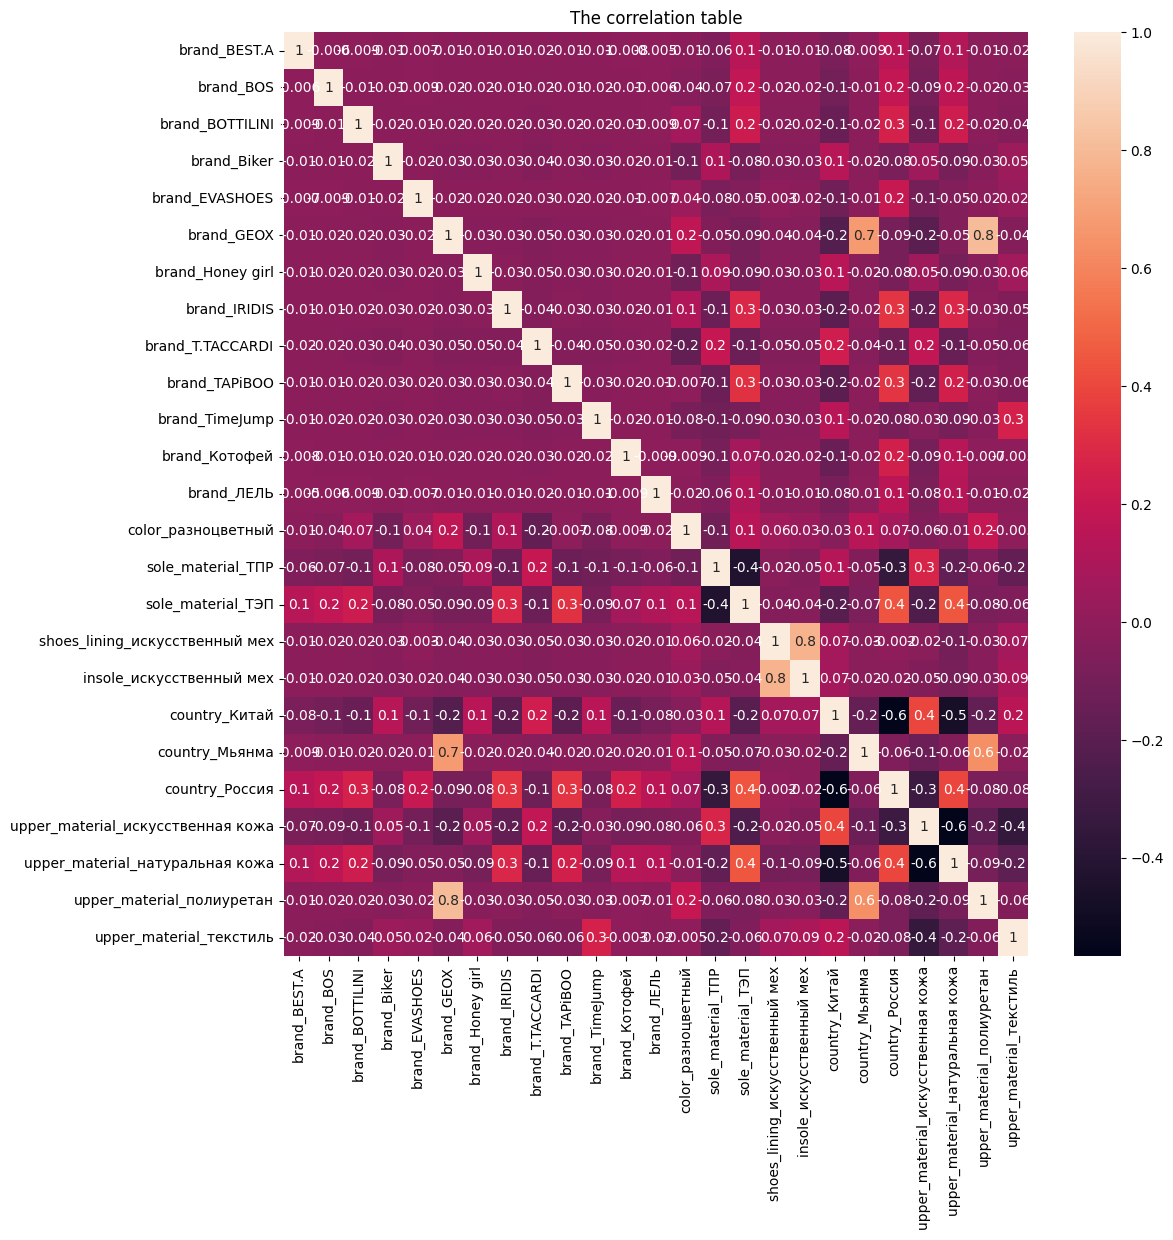

In [ ]:
plt.figure(figsize=(12, 12))
heatmap = sns.heatmap(data=data[best_features].corr(), annot=True, fmt='.1g')
heatmap.set_title('The correlation table', fontsize=12);

Уберем сильнокоррелирующие признаки из обучающего набора.

In [ ]:
y = data['price']
X = data.drop(columns=['insole_искусственный мех','brand_GEOX','price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Выбранные метрики:

* Средняя абсолютная ошибка: MAE. Насколько в среднем предсказанный результат разошелся с реальным.

* Средняя абсолютная ошибка в процентах: MAPE.

* Квадратный корень из среднеквадратической ошибки: RMSE. Показывает отклонение от истинных ответов.

* Коэффициент детерминации: R2. Показывает степень сходства исходных данных и предсказанных: чем ближе к 1, тем качественнее работает модель. Отрицательный показатель говорит о том, что модель абсолютно не описывает зависимости в данных.

# Обучение моделей.

Обучим и сделаем предсказания с помощью 4 моделей:
1. Линейная регрессия, в том числе с l2 регуляризацией.
2. Дерево решений.
3. Случайный лес.
4. Градиентный бустинг.


## Линейная регрессия.

Построим модель линейной регрессии.

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_predicted = lr.predict(X_test)

#Рассчитываем метрики
print('MAE score:  {:.2f}'.format(metrics.mean_absolute_error(y_test, y_predicted)))
print('MAPE score: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_test, y_predicted)*100))
print('RMSE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_predicted))))
print('R2 score:   {:.2f}'.format(metrics.r2_score(y_test, y_predicted)))

MAE score:  7759621263817.75
MAPE score: 737455091870.73
RMSE score: 69612476758158.03
R2 score:   -8325277400246645686272.00


К сожалению, модель не выявила зависимости. Связь нелинейная, попробуем обучить модель на полиномиальных признаках второй степени.

In [ ]:
#Создаем объект для генерации полиномиальных признаков степени 2
poly = PolynomialFeatures(degree=2, include_bias=False)

poly.fit(X_train)
X_train_poly = poly.transform(X_train)
X_test_poly = poly.transform(X_test)

lr.fit(X_train_poly, y_train)
y_predicted = lr.predict(X_test_poly)

#Рассчитываем метрики
print('MAE score:  {:.2f}'.format(metrics.mean_absolute_error(y_test, y_predicted)))
print('MAPE score: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_test, y_predicted) * 100))
print('RMSE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_predicted))))
print('R2 score:   {:.2f}'.format(metrics.r2_score(y_test, y_predicted)))

MAE score:  76687716089968.81
MAPE score: 6414041442896.88
RMSE score: 345174480713832.12
R2 score:   -204692486560217235980288.00


Чтобы избежать огромных значений, используем L2-регуляризацию и снова обучим на полиномиальных признаках.

In [ ]:
ridge_lr_poly = Ridge(alpha=0.6)

ridge_lr_poly.fit(X_train_poly, y_train)

y_predicted = ridge_lr_poly.predict(X_test_poly)

#Рассчитываем метрики
print('MAE score:  {:.2f}'.format(metrics.mean_absolute_error(y_test, y_predicted)))
print('MAPE score: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_test, y_predicted) * 100))
print('RMSE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_predicted))))
print('R2 score:   {:.2f}'.format(metrics.r2_score(y_test, y_predicted)))

MAE score:  290.57
MAPE score: 17.72
RMSE score: 415.03
R2 score:   0.70


Уже лучше, модель в реднем ошибается в пределах 18%.

## Дерево решений.

Используем дерево решений.

In [ ]:
tree = DecisionTreeRegressor(
    max_depth=8,
    min_samples_leaf=3,
    random_state = 42)

tree.fit(X_train, y_train)

y_predicted = tree.predict(X_test)

#Рассчитываем метрики
print('MAE score:  {:.2f}'.format(metrics.mean_absolute_error(y_test, y_predicted)))
print('MAPE score: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_test, y_predicted) * 100))
print('RMSE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_predicted))))
print('R2 score:   {:.2f}'.format(metrics.r2_score(y_test, y_predicted)))

MAE score:  407.18
MAPE score: 28.44
RMSE score: 532.37
R2 score:   0.51


Метрики снизились. Для повышения до уровня полиномиальной регрессии можно увеличить глубину до 19, но это грозит переобучением. Поэтому дерево осталось относительно неглубоким.

## Случайный лес.

Пробуем обучить Случайный Лес.

In [ ]:
rf = RandomForestRegressor(n_estimators=100,
                           max_depth=8,
                           min_samples_leaf=3,
                           random_state=42)

rf.fit(X_train, y_train)

y_predicted = rf.predict(X_test)

#Рассчитываем метрики
print('MAE score:  {:.2f}'.format(metrics.mean_absolute_error(y_test, y_predicted)))
print('MAPE score: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_test, y_predicted) * 100))
print('RMSE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_predicted))))
print('R2 score:   {:.2f}'.format(metrics.r2_score(y_test, y_predicted)))

MAE score:  393.16
MAPE score: 27.93
RMSE score: 506.92
R2 score:   0.56


Метрика повысилась незначительно, по-прежнему ниже уровня полиномиальной регрессии.

## Градиентный бустинг.

Пробуем обучить модель градиентного бустинга. Если деревья обучаются параллельно и не передают информацию об ошибках друг другу, то модель градиентного бустинга уделяет ошибкам много внимания: она на них обучается.

In [ ]:
gb = GradientBoostingRegressor(
    alpha=0.5,
    max_depth=6,
    min_samples_leaf=3,
    n_estimators=500,
    random_state=42)

gb.fit(X_train, y_train)

y_predicted = gb.predict(X_test)

#Рассчет метрик
print('MAE score:  {:.2f}'.format(metrics.mean_absolute_error(y_test, y_predicted)))
print('MAPE score: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_test, y_predicted) * 100))
print('RMSE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_predicted))))
print('R2 score:   {:.2f}'.format(metrics.r2_score(y_test, y_predicted)))

MAE score:  278.19
MAPE score: 17.31
RMSE score: 400.62
R2 score:   0.72


500 неглубоких деревьев повысили метрику немного превзошли метрики, расчитанные для полиномиальной регрессии 2 степени.Попробуем модель XGBRegressor.






In [ ]:
xgb_model = xgb.XGBRegressor(
    eta=0.4,
    max_depth=6,
    max_leaves=15,
    n_estimators=500,
    random_state=42)
xgb_model.fit(X_train, y_train)

# Получение предсказаний
y_predicted = xgb_model.predict(X_test)

#Рассчет метрик
print('MAE score:  {:.2f}'.format(metrics.mean_absolute_error(y_test, y_predicted)))
print('MAPE score: {:.2f}'.format(metrics.mean_absolute_percentage_error(y_test, y_predicted) * 100))
print('RMSE score: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_predicted))))
print('R2 score:   {:.2f}'.format(metrics.r2_score(y_test, y_predicted)))

MAE score:  258.29
MAPE score: 15.53
RMSE score: 383.55
R2 score:   0.75


Мы добились возможных высоких метрик. Ошибка в районе 16% является приемлемой. Определим 3 признака, которые вносят наибольший вклад при пргнозировании цены.

<Axes: >

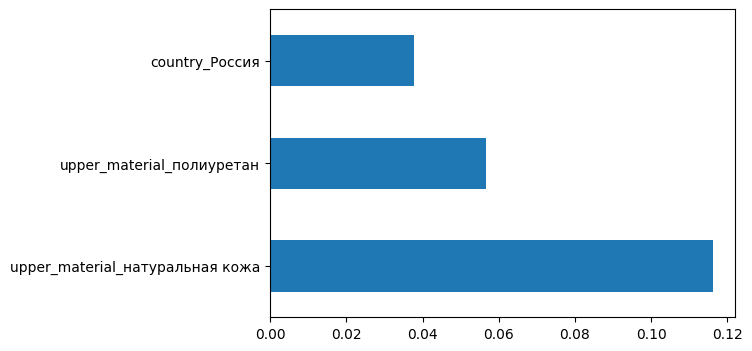

In [ ]:
plt.rcParams['figure.figsize'] = (6,4)
best_fea = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
best_fea.nlargest(3).plot(kind='barh')

Итак, на цену детской обуви влияет прежде всего материал верха: натуральная кожа всегда будет стоить дороже из-за износостойкости.  Также весной пользуются спросом резиновые сапоги (из полиуретана). Обувь, которая изготавливается в России до 30% может превышать китайский аналог. Поэтому некоторые российские бренды (например, "Сказка") переносят производство в Китай.